# "Doe Arena Corinthians" — Análise da Campanha


No dia 27 de novembro de 2024, teve início a campanha de arrecadação de fundos para quitação da dívida do estádio Arena Corinthians. Promovida pela Gaviões da Fiel, a campanha disponibiliza as informações de arrecadação através do [site oficial](https://www.doearenacorinthians.com.br) a fim de conferir transparência à iniciativa.

Com base nas informações disponibilizadas, analisamos a evolução da campanha ao longo do tempo sob diferentes perspectivas. Geramos dados estatísticos e fazemos algumas predições usando algoritmos de aprendizado de máquina (*machine learning*) e de análise de séries temporais (*time series analysis*).

Este *notebook* foi elaborado de maneira independente por alguém apaixonado pelo Sport Club Corinthians Paulista — nosso Timão — e por computação, e busca somar a outras análises disponíveis na Internet. Alguns exemplos dessas outras análises são [este](https://docs.google.com/spreadsheets/d/1DjH9NyPgFJ5hhnNY3E_e0uqkYHoPo7Xhl-XtmEdnLxU/edit) painel de dados (*dashboard*) desenvolvido pelo Victor Pelizaro e as publicações do [@numero7oficial](https://www.threads.net/@numero7oficial) no Threads.

⚠️ **ATENÇÃO:** Os algoritmos utilizados na predição se baseiam em informações passadas para prever comportamento futuro. Isso significa que os valores estimados podem estar errados — no caso do Corinthians, muito errados ("quarta força", "0,004%"). Portanto, tenha cautela ao examiná-los!

***Vaaai, Corinthians!***

Autor: Patrick Franco Coutinho \
Última Atualização: 13/12/2024

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np
print(f"Numpy version: {np.__version__}")

import pandas as pd
print(f"Pandas version: {pd.__version__}")

import seaborn as sns
print(f"Seaborn version: {sns.__version__}")

Numpy version: 2.1.3
Pandas version: 2.2.3
Seaborn version: 0.13.2


## Análise Preliminar: Meta de Arrecadação Diária

O objetivo da campanha é arrecadar R$ 700 milhões em seis meses. Alguns portais de notícias informam que a data final da campanha é 10 de maio de 2025. A *meta de arrecadação diária* é o valor que deve ser arrecadado *em média* por dia para que a campanha atinja o objetivo no prazo determinado.

In [2]:
# Objetivo de arrecadação da campanha
FUNDRAISING_GOAL = 700 * 10**6  # R$ 700 milhões

# Datas
DATE_BEGIN = "27/11/2024"  # Início
DATE_END = "10/05/2025"    # Fim (previsto)

DATE_FMT = "%d/%m/%Y"

date_begin = datetime.strptime(DATE_BEGIN, DATE_FMT)
date_end = datetime.strptime(DATE_END, DATE_FMT)

# Duração da campanha (em dias)
campaign_duration = (date_end - date_begin).days  # + 1 (para o cálculo incluir a data inicial)

# Meta de arrecadação diária
daily_goal = FUNDRAISING_GOAL / campaign_duration

print(f"A meta de arrecadação diária é de R$ {daily_goal:.2f}.")

A meta de arrecadação diária é de R$ 4268292.68.


## Análise Exploratória dos Dados da Campanha

Informações sobre a arrecadação disponibilizadas no [site oficial](https://www.doearenacorinthians.com.br/) da campanha são reunidas em uma tabela contendo os seguintes campos (colunas):

1. `arrecadacao_total`: valor total arrecadado até `data` e `horario` informados;
2. `data`: data (formato "dd/mm/aaaa");
3. `horario`: horário (formato "hh:mm").

Esse conjunto de dados tem as seguintes características:

- não apresenta dados faltantes (*missing values*);
- não apresenta dados duplicados;
- uma mesma data pode ter múltiplas entradas com horários e valores de arrecadação total diferentes;
- intervalo de tempo irregular entre os dados;
- pode conter intervalos de tempo sem dados (*e.g.*, no período de manutenção do sistema da Caixa Econômica Federal).

In [3]:
# Dados de arrecadação da campanha
CSV_FILE = "dataset/arrecadacao_DoeArenaCorinthians.csv"

campaign_df = pd.read_csv(CSV_FILE)

campaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5073 entries, 0 to 5072
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   arrecadacao_total  5073 non-null   float64
 1   data               5073 non-null   object 
 2   horario            5073 non-null   object 
dtypes: float64(1), object(2)
memory usage: 119.0+ KB


In [4]:
campaign_df.head()

,arrecadacao_total,data,horario
0,107077.30,27/11/2024,19:05
1,169205.39,27/11/2024,20:06
2,188873.67,27/11/2024,20:55
3,1012845.38,27/11/2024,22:40
4,2015864.75,28/11/2024,02:45


In [5]:
campaign_df.tail()

,arrecadacao_total,data,horario
5068,30351560.32,14/12/2024,12:50
5069,30352001.32,14/12/2024,12:52
5070,30353246.32,14/12/2024,12:55
5071,30353816.32,14/12/2024,12:57
5072,30354396.32,14/12/2024,13:00


### Evolução Diária da Campanha

A fim de acompanharmos a evolução diária da campanha, vamos "refinar" os dados presentes na tabela apresentada. Para isso, vamos construir uma segunda tabela chamada `daily_df` com os seguintes campos:

1. `dia_semana`: dia da semana;
2. `arrecadacao_total`: arrecadação total;
3. `arrecadacao_diaria`: arrecadação diária.

O índice utilizado é o `timestamp`, ou seja, o "carimbo" de data e horário. Isso facilita a etapa de reamostragem (*resampling*) dos dados, pois teremos apenas uma única entrada (linha) para cada data.

A arrecadação diária é obtida com base na arrecadação total. Seja $A_{T}(t)$ a arrecadação total no dia $t$. A arrecadação diária do dia $t$, $A_{d}(t)$, é dada por:

$$
A_{d}(t) = A_{T}(t) - A_{T}(t - 1)\text{.}
$$

Dessa maneira, buscamos tornar os dados "mais regulares" e informativos no período de tempo considerado.

In [6]:
daily_df = campaign_df.copy()

daily_df["timestamp"] = pd.to_datetime(daily_df["data"] + " " + daily_df["horario"], format="%d/%m/%Y %H:%M")
daily_df.drop(columns=["data", "horario"], inplace=True)
daily_df.set_index("timestamp", inplace=True)

# Seleciona a última entrada para cada data
daily_df = daily_df.resample("D").last()

daily_df["dia_semana"] = daily_df.index.day_name("pt_BR.utf8").str.lower()

# Cálculo da arrecadação diária
daily_df["arrecadacao_diaria"] = np.diff(np.r_[0, daily_df["arrecadacao_total"].to_numpy()])

# Reordenação das colunas
daily_df = daily_df[["dia_semana", "arrecadacao_diaria", "arrecadacao_total"]]

# Números menores
daily_df["arrecadacao_total"] = daily_df["arrecadacao_total"] / 10**6
daily_df["arrecadacao_diaria"] = daily_df["arrecadacao_diaria"] / 10**6

daily_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18 entries, 2024-11-27 to 2024-12-14
Freq: D
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dia_semana          18 non-null     object 
 1   arrecadacao_diaria  18 non-null     float64
 2   arrecadacao_total   18 non-null     float64
dtypes: float64(2), object(1)
memory usage: 576.0+ bytes


In [7]:
# Dados dos últimos sete dias
daily_df.tail(7)

,dia_semana,arrecadacao_diaria,arrecadacao_total
timestamp,,,
2024-12-08,domingo,0.527031,28.672191
2024-12-09,segunda,0.352832,29.025023
2024-12-10,terça,0.249907,29.274930
2024-12-11,quarta,0.263663,29.538593
2024-12-12,quinta,0.253202,29.791795
2024-12-13,sexta,0.401891,30.193686
2024-12-14,sábado,0.160710,30.354396


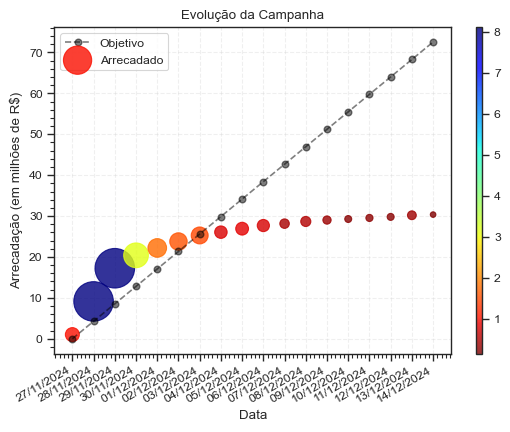

In [8]:
sns.set_theme(context="paper", style="white")
sns.set_style({"grid.linestyle": ":", "xtick.bottom": True, "ytick.left": True})

fig, ax = plt.subplots()

ax.plot(
    [date.strftime(DATE_FMT) for date in daily_df.index],
    daily_goal * np.array([(date - date_begin).days for date in daily_df.index]) / 10**6,
    marker="o",
    linestyle="dashed",
    color="black",
    alpha=0.5,
    label="Objetivo"
)

sct_ax = ax.scatter(
    [date.strftime(DATE_FMT) for date in daily_df.index],
    daily_df["arrecadacao_total"],
    c=daily_df["arrecadacao_diaria"],
    sizes=daily_df["arrecadacao_diaria"] * 100,
    cmap="jet_r",
    alpha=0.8,
    label="Arrecadado"
)

fig.colorbar(sct_ax, aspect=50)

ax.set_title("Evolução da Campanha")
ax.set_xlabel("Data")
ax.set_ylabel("Arrecadação (em milhões de R$)")
ax.legend()

ax.minorticks_on()
ax.grid(visible=True, which="major", alpha=0.3, linestyle="--")

fig.autofmt_xdate()

### Arrecadação Diária da Campanha

No gráfico anterior, o tamanho dos círculos coloridos dá uma noção da arrecadação diária. Para observarmos a série temporal com mais clareza, vamos construir o gráfico de hastes com os valores diários.

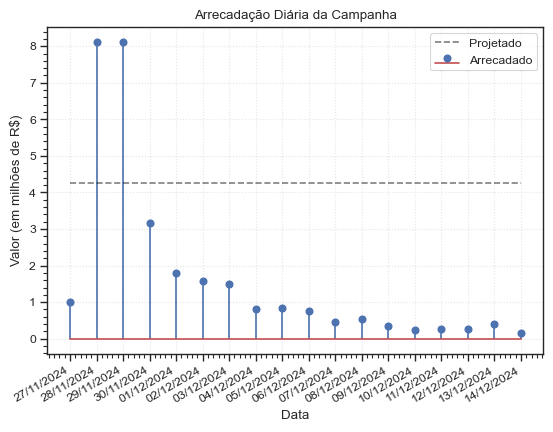

In [9]:
fig, ax = plt.subplots()

ax.stem(
    [date.strftime(DATE_FMT) for date in daily_df.index],
    daily_df["arrecadacao_diaria"],
    label="Arrecadado",
)

ax.plot(
    [daily_df.index[0].strftime(DATE_FMT), daily_df.index[-1].strftime(DATE_FMT)],
    np.array([daily_goal, daily_goal]) / 10**6,
    linestyle="--",
    color="black",
    alpha=0.5,
    label="Projetado"
)

ax.set_title("Arrecadação Diária da Campanha")
ax.set_ylabel("Valor (em milhões de R$)")
ax.set_xlabel("Data")
ax.legend()

ax.minorticks_on()
ax.grid(visible=True, which="major", alpha=0.5)

fig.autofmt_xdate()

### Arrecadação Diária vs. Dias da Semana

Vamos os dados de arrecadação para cada dia da semana.

O gráfico utilizado para exibir a relação entre a arrecadação diária e os dias da semana é chamado de *diagrama de caixa* (ou *boxplot*). Ao longo da campanha, este gráfico nos ajudará a identificar valores da arrecadação diária que são considerados *outliers*, ou seja, dados que destoam significativamente do resto do conjunto (na campanha, os *outliers* representam valores extremamente baixos ou extremamente altos de arrecadação).

Você pode ler mais sobre o diagrama de caixa [neste link](https://www.itl.nist.gov/div898/handbook/eda/section3/boxplot.htm).

In [10]:
# Dados agrupados de acordo com o dia da semana (domingo, segunda, etc.)
dow_gp = daily_df.groupby("dia_semana", as_index=True, sort=False)

dow_gp["arrecadacao_diaria"].describe()

,count,mean,std,min,25%,50%,75%,max
dia_semana,,,,,,,,
quarta,3.0,0.693840,0.386766,0.263663,0.534337,0.805011,0.908928,1.012845
quinta,3.0,3.070091,4.373596,0.253202,0.550848,0.848495,4.478535,8.108576
sexta,3.0,3.094947,4.351840,0.401891,0.584627,0.767363,4.441475,8.115587
sábado,3.0,1.263707,1.652598,0.160710,0.313675,0.466640,1.815206,3.163771
domingo,2.0,1.163650,0.900315,0.527031,0.845341,1.163650,1.481960,1.800269
segunda,2.0,0.962846,0.862691,0.352832,0.657839,0.962846,1.267854,1.572861
terça,2.0,0.866824,0.872453,0.249907,0.558366,0.866824,1.175283,1.483742


In [11]:
# Mediana da arrecadação diária para cada dia da semana
dow_gp[["arrecadacao_diaria"]].median()

,arrecadacao_diaria
dia_semana,
quarta,0.805011
quinta,0.848495
sexta,0.767363
sábado,0.466640
domingo,1.163650
segunda,0.962846
terça,0.866824


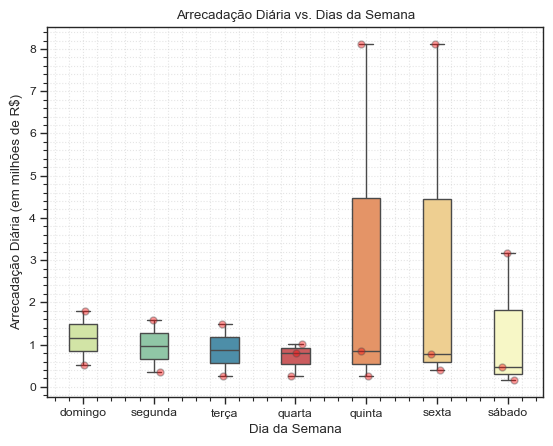

In [12]:
ax = sns.boxplot(
    x="dia_semana",
    y="arrecadacao_diaria",
    data=daily_df,
    fill=True,
    width=0.4,
    order=["domingo", "segunda", "terça", "quarta", "quinta", "sexta", "sábado"],
    hue="dia_semana",
    palette="Spectral",
)

sns.stripplot(
    x="dia_semana",
    y="arrecadacao_diaria",
    data=daily_df,
    linewidth=1,
    color="red",
    alpha=0.4
)

ax.set_title("Arrecadação Diária vs. Dias da Semana")
ax.set_xlabel("Dia da Semana")
ax.set_ylabel("Arrecadação Diária (em milhões de R$)")

ax.minorticks_on()
ax.grid(visible=True, which="both", alpha=0.5)

## "Doe Arena Corinthians" vs. *Machine Learning*

Nesta seção, utilizaremos algoritmos de aprendizado de máquina (*machine learning*) e de análise de séries temporais (*time series analysis*) para fazermos predições (*i.e.*, previsões). **EM BREVE!**

### Predições de Arrecadação Total

### Predições de Arrecadação Diária